# Imports

In [1]:
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from bs4 import BeautifulSoup
import requests
import pandas as pd
import validators
from urllib.parse import urlparse
import json
import string
from string import digits
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

sns.set()

In [2]:
%load_ext dotenv
%dotenv

# Initializing the Google Sheets API

**NOTE**: Use https://developers.google.com/sheets/api/quickstart/python to first create a Google Cloud project and enable the Google Sheets API. Then download the `credentials.json` to the same directory as this script.

In [3]:
# The ID and range of a sample spreadsheet.
SPREADSHEET_ID = os.getenv("SPREADSHEET_ID")
GENERAL_RANGE = "GENERAL!C:S"
AGRI_RANGE = "AGRICULTURE!C:S"
FIN_RANGE = "FINANCE!C:S"
DUP_RANGE = "DUPLICATES!A1:A1005"
UN_RANGE = "UNADDED!A:B"
EX_RANGE = "EXTRA!A1:A10001"
RANGES = [AGRI_RANGE, FIN_RANGE, GENERAL_RANGE]

# Accessing Sheets, finding duplicates and unadded links

## Generating token to access the API

In [4]:
# If modifying these scopes, delete the file write-token.json and read-token.json

# SCOPES = ["https://www.googleapis.com/auth/spreadsheets.readonly"] # For read-only scope
SCOPES = ["https://www.googleapis.com/auth/spreadsheets"]  # For writing to sheet

In [5]:
creds = None

if os.path.exists("write-token.json"):
    creds = Credentials.from_authorized_user_file("write-token.json", SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file("credentials.json", SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open("write-token.json", "w") as token:
        token.write(creds.to_json())

service = build("sheets", "v4", credentials=creds)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=866438115849-109dmktdu3k3c8su4ict16qf3m8ehqal.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A54908%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fspreadsheets&state=GnrzT3YkX4blEaO4c0QLG18c5t2yHW&access_type=offline


## Getting Sitemaps from Gurturgoth and Anjor

In [8]:
# Gurturgoth Sitemaps
gg_sitemaps = [
    f"https://hanka.gurturgoth.com/post-sitemap{i}.xml" for i in range(1, 6 + 1)
]
gg_sitemaps

['https://hanka.gurturgoth.com/post-sitemap1.xml',
 'https://hanka.gurturgoth.com/post-sitemap2.xml',
 'https://hanka.gurturgoth.com/post-sitemap3.xml',
 'https://hanka.gurturgoth.com/post-sitemap4.xml',
 'https://hanka.gurturgoth.com/post-sitemap5.xml',
 'https://hanka.gurturgoth.com/post-sitemap6.xml']

In [10]:
# Anjor Sitemaps
an_sitemaps = [
    f"https://www.anjor.online/sitemap.xml?page={i}" for i in range(1, 14 + 1)
]
an_sitemaps

['https://www.anjor.online/sitemap.xml?page=1',
 'https://www.anjor.online/sitemap.xml?page=2',
 'https://www.anjor.online/sitemap.xml?page=3',
 'https://www.anjor.online/sitemap.xml?page=4',
 'https://www.anjor.online/sitemap.xml?page=5',
 'https://www.anjor.online/sitemap.xml?page=6',
 'https://www.anjor.online/sitemap.xml?page=7',
 'https://www.anjor.online/sitemap.xml?page=8',
 'https://www.anjor.online/sitemap.xml?page=9',
 'https://www.anjor.online/sitemap.xml?page=10',
 'https://www.anjor.online/sitemap.xml?page=11',
 'https://www.anjor.online/sitemap.xml?page=12',
 'https://www.anjor.online/sitemap.xml?page=13',
 'https://www.anjor.online/sitemap.xml?page=14']

In [11]:
def get_sitemap_links(sitemaps):
    """
    Returns all the URLs found in the sitemaps
    """

    all_urls = set()
    header = {
        "Accept": "*/*",
        "Accept-Language": "*",
        "Accept-Encoding": "identity, gzip, deflate, compress, br",
        "User-Agent": "XY",
    }

    for sitemap in sitemaps:
        r = requests.get(sitemap, headers=header)
        xml = r.text

        soup = BeautifulSoup(xml)
        URLTags = soup.find_all("url")

        print(f"{sitemap}: {len(URLTags)} urls found")

        for URL in URLTags:
            all_urls.add(URL.findNext("loc").text)

    print(f"Total: {len(all_urls)} links found")

    return list(all_urls)

In [12]:
gg_links = get_sitemap_links(gg_sitemaps)

https://hanka.gurturgoth.com/post-sitemap1.xml: 1000 urls found
https://hanka.gurturgoth.com/post-sitemap2.xml: 1000 urls found
https://hanka.gurturgoth.com/post-sitemap3.xml: 1000 urls found
https://hanka.gurturgoth.com/post-sitemap4.xml: 1000 urls found
https://hanka.gurturgoth.com/post-sitemap5.xml: 1000 urls found
https://hanka.gurturgoth.com/post-sitemap6.xml: 272 urls found
Total: 5272 links found


In [13]:
an_links = get_sitemap_links(an_sitemaps)

https://www.anjor.online/sitemap.xml?page=1: 150 urls found
https://www.anjor.online/sitemap.xml?page=2: 150 urls found
https://www.anjor.online/sitemap.xml?page=3: 150 urls found
https://www.anjor.online/sitemap.xml?page=4: 150 urls found
https://www.anjor.online/sitemap.xml?page=5: 150 urls found
https://www.anjor.online/sitemap.xml?page=6: 150 urls found
https://www.anjor.online/sitemap.xml?page=7: 150 urls found
https://www.anjor.online/sitemap.xml?page=8: 150 urls found
https://www.anjor.online/sitemap.xml?page=9: 150 urls found
https://www.anjor.online/sitemap.xml?page=10: 150 urls found
https://www.anjor.online/sitemap.xml?page=11: 150 urls found
https://www.anjor.online/sitemap.xml?page=12: 150 urls found
https://www.anjor.online/sitemap.xml?page=13: 150 urls found
https://www.anjor.online/sitemap.xml?page=14: 100 urls found
Total: 2050 links found


## Save the sitemaps as CSVs

In [14]:
def save_as_csv(filename, links, foldername=""):
    """
    Saves a list of links as CSV files
    filename: Name of the file to save the csv as
    links: a collection of links to save in the csv
    foldername: Name of the folder to save the file
    """
    df = pd.DataFrame(data={"links": list(links)})
    if foldername:
        if not os.path.exists(foldername):
            os.mkdir(foldername)
        df.to_csv(os.path.join(foldername, filename), sep=",", index=False)
    else:
        df.to_csv(filename, sep=",", index=False)

In [15]:
save_as_csv("anjor.csv", an_links, "sitemaps")
save_as_csv("gurtur.csv", gg_links, "sitemaps")

## Get the data summary from Google Sheets

In [16]:
# Call the Sheets API
sheet = service.spreadsheets()
result = sheet.values().batchGet(spreadsheetId=SPREADSHEET_ID, ranges=RANGES).execute()
ranges = result.get("valueRanges", [])

sheet_links = set()
duplicate_links = set()
link_count = 0

if not ranges:
    print("No data found.")
else:
    print(f"{len(ranges)} ranges retrieved.")
    for single_range in ranges:
        range_count = 0
        for row in single_range["values"]:
            if len(row) != 0:
                for item in row:
                    if validators.url(item):
                        range_count += 1
                        if item in sheet_links:
                            duplicate_links.add(item)
                        else:
                            sheet_links.add(item)
        print(f"Total links in {single_range['range']}:\t{range_count}")
        link_count += range_count
    print()
    print(f"Total links in sheet:\t{link_count}")
    print(f"Unique links in sheet:\t{len(sheet_links)}")
    print(f"Duplicate links:\t{len(duplicate_links)}")

3 ranges retrieved.
Total links in AGRICULTURE!C1:S1236:	357
Total links in FINANCE!C1:S1234:	232
Total links in GENERAL!C1:S1943:	820

Total links in sheet:	1409
Unique links in sheet:	1409
Duplicate links:	0


In [17]:
# Verify duplicates
count = 0
for link in list(duplicate_links):
    if link in sheet_links:
        count += 1
print(count)

0


In [18]:
# Saving the duplicates
save_as_csv("duplicates.csv", duplicate_links, "duplicates")

## Writing duplicates to Google Sheets [Caution: Can overwrite to sheet]

In [19]:
# Writing to Google Sheets
values = [["DUPLICATES"]]

for value in list(duplicate_links):
    values.append([value])

len_values = len(values)

for _ in range(len_values, 1000 + 1):
    values.append([""])

body = {"values": values}

value_input_option = "USER_ENTERED"

In [20]:
result = (
    service.spreadsheets()
    .values()
    .update(
        spreadsheetId=SPREADSHEET_ID,
        range=DUP_RANGE,
        valueInputOption=value_input_option,
        body=body,
    )
    .execute()
)
print(f"{result.get('updatedCells')} cells updated.")

1001 cells updated.


## Finding links Gurturgoth and Anjor that are not in the sheet

In [21]:
# Getting the un-needed extra links
result = (
    service.spreadsheets()
    .values()
    .get(spreadsheetId=SPREADSHEET_ID, range=EX_RANGE)
    .execute()
)
extra = result.get("values", [])
print(f"{len(extra)} rows retrieved.")

47 rows retrieved.


In [22]:
# Gurturgoth links not in sheet
unadded_gg_links = []
for link in gg_links:
    if link not in sheet_links and link not in extra:
        unadded_gg_links.append(link)

print(f"Number of Gurturgoth links not in sheet: {len(unadded_gg_links)}")

Number of Gurturgoth links not in sheet: 4063


In [23]:
# Anjor links not in sheet
unadded_an_links = []
for link in an_links:
    if link not in sheet_links and link not in extra:
        unadded_an_links.append(link)

print(f"Number of Anjor links not in sheet: {len(unadded_an_links)}")

Number of Anjor links not in sheet: 1890


In [24]:
save_as_csv("unadded_gg_links.csv", unadded_gg_links, "unadded_links")

In [25]:
save_as_csv("unadded_an_links.csv", unadded_an_links, "unadded_links")

## Writing unadded links to Sheet [Caution: Can overwrite to sheet]

In [26]:
# Writing to Google Sheets
values = [["GURTUR", "ANJOR"]]

for i, gg_value in enumerate(list(unadded_gg_links)):
    an_value = ""
    if i < len(unadded_an_links):
        an_value = unadded_an_links[i]
    values.append([gg_value, an_value])

len_values = len(values)

for _ in range(len_values, 5000 + 1):
    values.append(["", ""])

body = {"values": values}

value_input_option = "USER_ENTERED"

In [27]:
result = (
    service.spreadsheets()
    .values()
    .update(
        spreadsheetId=SPREADSHEET_ID,
        range=UN_RANGE,
        valueInputOption=value_input_option,
        body=body,
    )
    .execute()
)
print(f"{result.get('updatedCells')} cells updated.")

10002 cells updated.


# Extracting data from the collected links and cleaning them

## Generating token to access the API

In [28]:
# If modifying these scopes, delete the file write-token.json and read-token.json

SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets.readonly"
]  # For read-only scope
# SCOPES = ["https://www.googleapis.com/auth/spreadsheets"]  # For writing to sheet

In [42]:
creds = None

if os.path.exists("read-token.json"):
    creds = Credentials.from_authorized_user_file("read-token.json", SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file("credentials.json", SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open("read-token.json", "w") as token:
        token.write(creds.to_json())

service = build("sheets", "v4", credentials=creds)

RefreshError: ('invalid_grant: Bad Request', {'error': 'invalid_grant', 'error_description': 'Bad Request'})

## Helper Functions

In [8]:
def is_gurtur(link):
    parsed_uri = urlparse(link)
    result = "{uri.scheme}://{uri.netloc}/".format(uri=parsed_uri)
    return (
        result == "https://hanka.gurturgoth.com/"
        or result == "http://hanka.gurturgoth.com/"
    )

In [9]:
def is_anjor(link):
    parsed_uri = urlparse(link)
    result = "{uri.scheme}://{uri.netloc}/".format(uri=parsed_uri)
    return result == "https://www.anjor.online/" or result == "http://www.anjor.online/"

In [10]:
def is_patrika(link):
    parsed_uri = urlparse(link)
    result = "{uri.scheme}://{uri.netloc}/".format(uri=parsed_uri)
    return result == "https://www.patrika.com/" or result == "http://www.patrika.com/"

In [11]:
def is_36garhi(link):
    parsed_uri = urlparse(link)
    result = "{uri.scheme}://{uri.netloc}/".format(uri=parsed_uri)
    return result == "https://36garhi.com/" or result == "http://36garhi.com/"

In [12]:
def is_hindi_news18(link):
    parsed_uri = urlparse(link)
    result = "{uri.scheme}://{uri.netloc}/".format(uri=parsed_uri)
    return (
        result == "https://hindi.news18.com/" or result == "http://hindi.news18.com/"
    ) and parsed_uri.path.startswith("/news/chhattisgarhi/")

In [13]:
# Tests

assert is_gurtur("https://hanka.gurturgoth.com/mrs-devendra-kumari-singhdev/") == True
assert is_gurtur("http://hanka.gurturgoth.com/mrs-devendra-kumari-singhdev/") == True
assert is_gurtur("https://www.anjor.online/2021/05/baldi-bai.jpg.html") == False

assert is_anjor("https://www.anjor.online/2021/05/baldi-bai.jpg.html") == True
assert is_anjor("http://www.anjor.online/2021/05/baldi-bai.jpg.html") == True
assert is_anjor("https://hanka.gurturgoth.com/mrs-devendra-kumari-singhdev/") == False

assert is_patrika("https://hanka.gurturgoth.com/mrs-devendra-kumari-singhdev/") == False
assert is_patrika("https://www.anjor.online/2021/05/baldi-bai.jpg.html") == False
assert (
    is_patrika("https://www.patrika.com/raipur-news/chattisgarhi-sahitya-6522552/")
    == True
)
assert (
    is_patrika("http://www.patrika.com/raipur-news/chattisgarhi-sahitya-6522552/")
    == True
)

assert (
    is_36garhi(
        "https://36garhi.com/2021/05/15/%e0%a4%b9%e0%a4%bf%e0%a4%9c%e0%a4%97%e0%a4%be/"
    )
    == True
)
assert (
    is_36garhi(
        "https://36garhi.com/2021/05/15/%e0%a4%9a%e0%a4%a8%e0%a5%8d%e0%a4%a6%e0%a5%82%e0%a4%b2%e0%a4%be%e0%a4%b2-%e0%a4%9a%e0%a4%a8%e0%a5%8d%e0%a4%a6%e0%a5%8d%e0%a4%b0%e0%a4%be%e0%a4%95%e0%a4%b0-%e0%a4%aa%e0%a5%81%e0%a4%b0%e0%a4%b8%e0%a5%8d/"
    )
    == True
)
assert is_36garhi("https://www.anjor.online/2021/05/baldi-bai.jpg.html") == False

assert (
    is_hindi_news18(
        "https://hindi.news18.com/news/chhattisgarhi/chhattisgarhi-epigraphy-epidemic-corona-navratri-ramleela-planetarium-astronomical-nodakm-3317016.html"
    )
    == True
)
assert is_hindi_news18("https://www.anjor.online/2021/05/baldi-bai.jpg.html") == False

assert (
    is_hindi_news18(
        "https://hindi.news18.com/videos/news18-virals/news18-virals-himachal-pradesh/hp-board-12th-results-meet-pushpendra-of-kullu-who-scored-500-out-of-500-in-class-12th-3656240.html?utm_source=jionews?utm_source=jionews"
    )
    == False
)

In [14]:
num_chars = 128
devnagri_chars = []
for i in range(num_chars):
    devnagri_chars.append(chr(ord("ऀ") + i))

In [15]:
def has_devnagri(text):
    return any(dev_char in text for dev_char in devnagri_chars)

## Get data from Sheets API

In [43]:
def read_from_link(link):
    """
    Gets the data from page source and extracts the contents if the
    page belongs to one of the top sites
    """
    header = {
        "Accept": "*/*",
        "Accept-Language": "*",
        "Accept-Encoding": "identity, gzip, deflate, compress, br",
        "User-Agent": "XY",
    }
    content = ""

    try:
        page = requests.get(link, headers=header)
        soup = BeautifulSoup(page.content, "html.parser")
    except:
        return content

    if is_gurtur(link):
        if content_soup := soup.find("div", class_="entry-content"):
            contents = []
            if tags := content_soup.find_all(["p", "span", "div"]):
                for tag in tags:
                    useful_text = ""
                    for text in tag.find_all(text=True):
                        if has_devnagri(text):
                            useful_text = " ".join([useful_text, text.strip()])
                    if useful_text:
                        contents.append(useful_text)
            if not contents:
                for text in content_soup.find_all(text=True):
                    useful_text = ""
                    if has_devnagri(text):
                        useful_text = " ".join([useful_text, text.strip()])
                        if useful_text:
                            contents.append(useful_text)
            content = (" ").join(contents).strip()

    elif is_anjor(link):
        if content_soup := soup.find("div", class_="entry-content"):
            contents = []
            if tags := content_soup.find_all(["p", "span", "div"]):
                for tag in tags:
                    useful_text = ""
                    for text in tag.find_all(text=True):
                        if has_devnagri(text):
                            useful_text = " ".join([useful_text, text.strip()])
                    if useful_text:
                        contents.append(useful_text)
            if not contents:
                for text in content_soup.find_all(text=True):
                    useful_text = ""
                    if has_devnagri(text):
                        useful_text = " ".join([useful_text, text.strip()])
                        if useful_text:
                            contents.append(useful_text)
            content = (" ").join(contents).strip()

    elif is_patrika(link):
        if content_soup := soup.find("div", class_="complete-story"):
            contents = []
            if tags := content_soup.find_all(["p", "span", "div"]):
                for tag in tags:
                    useful_text = ""
                    for text in tag.find_all(text=True):
                        if has_devnagri(text):
                            useful_text = " ".join([useful_text, text.strip()])
                    if useful_text:
                        contents.append(useful_text)
            if not contents:
                for text in content_soup.find_all(text=True):
                    useful_text = ""
                    if has_devnagri(text):
                        useful_text = " ".join([useful_text, text.strip()])
                        if useful_text:
                            contents.append(useful_text)
            content = (" ").join(contents).strip()

    elif is_36garhi(link):
        if content_soup := soup.find("div", class_="entry-content"):
            contents = []
            if tags := content_soup.find_all(["p", "span", "div"]):
                for tag in tags:
                    useful_text = ""
                    for text in tag.find_all(text=True):
                        if has_devnagri(text):
                            useful_text = " ".join([useful_text, text.strip()])
                    if useful_text:
                        contents.append(useful_text)
            if not contents:
                for text in content_soup.find_all(text=True):
                    useful_text = ""
                    if has_devnagri(text):
                        useful_text = " ".join([useful_text, text.strip()])
                        if useful_text:
                            contents.append(useful_text)
            content = (" ").join(contents).strip()

    elif is_hindi_news18(link):
        if content_soup := soup.find("div", class_="storypara"):
            contents = []
            for text in content_soup.find_all(text=True):
                useful_text = ""
                if has_devnagri(text):
                    useful_text = "".join([useful_text, text.strip()])
                    if useful_text:
                        if not ". " in useful_text:
                            contents.append(useful_text)
                        else:
                            for split_useful_text in useful_text.split(". "):
                                contents.append(split_useful_text.strip(".") + "।")
            content = ("").join(contents).strip()

    return content

In [44]:
def extract(ranges_list=["AGRI", "FIN", "GEN"], verbose=False):
    """
    Extracts the links from the given domain and stores them in json files
    """

    ranges_to_extract = []
    if "AGRI" in ranges_list:
        ranges_to_extract.append(AGRI_RANGE)
    if "FIN" in ranges_list:
        ranges_to_extract.append(FIN_RANGE)
    if "GEN" in ranges_list:
        ranges_to_extract.append(GENERAL_RANGE)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = (
        sheet.values()
        .batchGet(spreadsheetId=SPREADSHEET_ID, ranges=ranges_to_extract)
        .execute()
    )
    ranges = result.get("valueRanges", [])

    unscraped = []

    if not os.path.exists("check"):
        os.mkdir("check")
    check_f = open(os.path.join("check", "check_content.txt"), "w", encoding="utf-8")

    sheet_links = set()
    link_count = 0
    last_topic = ""

    if not ranges:
        print("No data found.")
    else:
        print(f"{len(ranges)} ranges retrieved\n")

        # Iterate over all domains in ranges
        for range_index, single_range in enumerate(ranges):
            print(f"In range {ranges_list[range_index]}\n")
            range_count = 0

            # Create folder if not already exists
            folder_name = single_range["range"].split("!")[0]
            if not os.path.exists(folder_name):
                os.makedirs(folder_name)

            for i, row in enumerate(single_range["values"]):
                index = 0
                if len(row) != 0 and i != 0:

                    # If topic exists in row
                    if row[0]:
                        last_topic = row[0]
                        subtopic = ""
                        if verbose:
                            print(f"Inside topic: {last_topic}")

                    # If subtopic exists in row
                    if len(row) > 1 and row[1] != "":
                        subtopic = row[1]
                        if verbose:
                            print(f"\tInside subtopic: {subtopic}")

                    for item in row:
                        if validators.url(item):
                            index += 1
                            range_count += 1

                            if (content := read_from_link(item)) == "":
                                unscraped.append(item)
                                continue
                            else:
                                check_f.write(item)
                                check_f.write("\n")
                                check_f.write(content)
                                check_f.write("\n\n")

                            data = {
                                "topic": last_topic,
                                "subtopic": subtopic,
                                "url": item,
                                "data": content,
                            }

                            if subtopic:
                                if not os.path.exists(
                                    os.path.join(folder_name, last_topic, subtopic)
                                ):
                                    os.makedirs(
                                        os.path.join(folder_name, last_topic, subtopic)
                                    )
                                with open(
                                    os.path.join(
                                        folder_name,
                                        last_topic,
                                        subtopic,
                                        f"{index}.json",
                                    ),
                                    "w",
                                    encoding="utf-8",
                                ) as f:
                                    json.dump(data, f)
                            else:
                                if not os.path.exists(
                                    os.path.join(folder_name, last_topic)
                                ):
                                    os.makedirs(os.path.join(folder_name, last_topic))
                                with open(
                                    os.path.join(
                                        folder_name, last_topic, f"{index}.json"
                                    ),
                                    "w",
                                    encoding="utf-8",
                                ) as f:
                                    json.dump(data, f)

            print(f"\nTotal links in {single_range['range']}:\t{range_count}\n")
            link_count += range_count

        print(f"\nTotal links in sheet:\t{link_count}")

    check_f.close()

    with open("unscraped.txt", "w", encoding="utf-8") as f:
        for link in unscraped:
            f.write(link)
            f.write("\n")

### Uncomment the below cell to run. Can take ~25 mins

In [ ]:
# extract(["AGRI", "FIN", "GEN"], verbose=False)

3 ranges retrieved

In range AGRI



## Verifying JSON data

In [45]:
f = open(os.path.join("AGRICULTURE", "Agricultural education", "1.json"))
sample_data = json.load(f)
sample_data

{'topic': 'Agricultural education',
 'subtopic': '',
 'url': 'https://hanka.gurturgoth.com/krishi-vigyan-kendra/',
 'data': 'बेमेतरा 19 मार्च 2021। कृषि विज्ञान केन्द्र, कृषि महाविद्यालय अउ अनुसंधान केन्द्र ढोलिया बेमेतरा के सापर तत्वधान म बिरस्पत 18 मार्च के जिला स्तरीय किसान मेला सह संगोष्ठी के आयोजन करे गइस। मेला के मुख्य उद्देश्य अलसी व दलहनी फसल अउ खरीफ/रबी फसल मन के बीज उत्पादन ल प्रोत्साहित करना रिहिन। (मेला अखिल भारतीय समन्वित अलसी अनुसंधान परियोजना, अखिल भारतीय समन्वित मुलार्प अनुसंधान परियोजना अउ राष्ट्रीय बीज परियोजना- मेगा सीड परियोजना डाहर ले प्रायोजित रिहिन।) कार्यक्रम म मुख्य अतिथि कृषि मंत्री श्री रविन्द्र चौबे  विशिष्ट अतिथि विधायक बेमेतरा श्री आशीष छाबड़ा, डा. एस. के. पाटील (कुलपति इंदिरागांधी कृषि विश्वविद्यालय रायपुर) डा. एस. सी. मुखर्जी निदेशक विस्तार सेवायें, इंदिरागांधी कृषि विश्वविद्यालय रायपुर, डा. आर. के. द्विवेदी अधिष्ठाता कृषि महाविद्यालय अउ अनुसंधान केन्द्र, कवर्धा, डाॅ. डी. एस. ठाकुर अधिष्ठाता कृषि महाविद्यालय अउ अनुसंधान केन्द्र, साजा, बंशी पटेल, श्रीमति प

## Search links from unadded, containing a particular substring

In [46]:
# Getting un-added links
result = (
    service.spreadsheets()
    .values()
    .get(spreadsheetId=SPREADSHEET_ID, range=UN_RANGE)
    .execute()
)
unadded = result.get("values", [])
print(f"{len(unadded)} rows retrieved.")

4064 rows retrieved.


In [47]:
gg_links = pd.read_csv(os.path.join("unadded_links", "unadded_an_links.csv"))
an_links = pd.read_csv(os.path.join("unadded_links", "unadded_gg_links.csv"))
combined_links = pd.concat([gg_links, an_links])

In [48]:
def find_links(combined_links, substring_list):
    """
    Gets all links from unadded that have a particular substring in them
    """
    matching_links = []
    for link in combined_links.iloc[:, 0].tolist():
        for substring in substring_list:
            if substring.lower() in link.lower():
                matching_links.append(link)
    return matching_links

In [49]:
# Testing
find_links(combined_links, ["kisan", "krishi"])

['https://www.anjor.online/2020/05/Rajiv-Gandhi-Kisan-Nyay-Yojana.html',
 'https://www.anjor.online/2020/05/kheti-kisani.html',
 'https://www.anjor.online/2020/05/rajiv-gandhi-kisan-nyay-yojana.html',
 'https://www.anjor.online/2021/05/bhupesh-baghel-cm-cg-kisan-naya-yoajan.html',
 'https://www.anjor.online/2021/03/rajiv-gandhi-kisan-nayay-yojana.html',
 'https://www.anjor.online/2021/07/rajiv-gandhi-kisan-nayay-yojana.html',
 'https://www.anjor.online/2020/04/kisan.html',
 'https://www.anjor.online/2021/08/rajiv-gandhi-gramin-bhumihin-krishi-majadur-nayay-yojana.html',
 'https://www.anjor.online/2020/08/bhupesh-baghel-kisan-yojana.html',
 'https://hanka.gurturgoth.com/during-the-lockdown-the-bhoomgadi-mahila-kisan-group-served-food-access-to-the-house/',
 'https://hanka.gurturgoth.com/kisan-hit-nirnay/',
 'https://hanka.gurturgoth.com/rajiv-gandhi-kisan-nyay-yojana-ke-kist/',
 'https://hanka.gurturgoth.com/gujarat-kisan-sahayata/',
 'https://hanka.gurturgoth.com/sabal-kisan/',
 'https

## Get links that have all topics, subtopics from the sheet in them

In [50]:
# Call the Sheets API
sheet = service.spreadsheets()
result = sheet.values().batchGet(spreadsheetId=SPREADSHEET_ID, ranges=RANGES).execute()
ranges = result.get("valueRanges", [])

sheet_links = set()
link_count = 0
last_topic = ""

if not ranges:
    print("No data found.")
else:
    print(f"{len(ranges)} ranges retrieved.\n")

    # Iterate over all domains i.e Agri, Finance, General
    for single_range in ranges:
        range_list = set()

        for i, row in enumerate(single_range["values"]):
            index = 0
            if len(row) != 0 and i != 0:

                # If topic exists in row
                if row[0]:
                    range_list.add("-".join(row[0].strip(digits).lower().split()))
                    # print(f"Inside topic: {row[0]}")

                # If subtopic exists in row
                if len(row) > 1 and row[1] != "":
                    range_list.add("-".join(row[1].strip(digits).lower().split()))
                    # print(f"\tInside subtopic: {row[1]}")

        # Create file to store the lists
        file_name = os.path.join(
            "unadded_links",
            "unadded_" + single_range["range"].split("!")[0].lower() + ".txt",
        )
        with open(file_name, "w", encoding="utf-8") as f:
            for link in find_links(combined_links, list(range_list)):
                f.write(link)
                f.write("\n")
print("Done!")

3 ranges retrieved.

Done!


## Removing punctuations

In [5]:
def remove_punct(text):

    text = re.sub(r"\s*[a-zA-Z]\s*", " ", text)

    # Removing numbers
    # text = re.sub('[0-9]', ' ' ,text)
    # Replacing पूर्ण विराम with full stop
    # text = re.sub('[।]','. ',text)

    # text = re.sub("\.\s", "। ", text)

    # Replacing all variants of single quatation marks with a uniform single quoration mark
    text = re.sub(r"\s*’\s*", "'", text)
    text = re.sub(r"\s*‘\s*", "'", text)
    text = re.sub(r"\s*'\s*", "'", text)

    # Replacing all variants of double quatation marks with a uniform double quoration mark
    text = re.sub(r"\s*“\s*", '"', text)
    text = re.sub(r"\s*”\s*", '"', text)
    text = re.sub(r'\s*"\s*', '"', text)

    # Unn-needed Character
    text = re.sub("\s*\xa0\s*", " ", text)

    # Removing special symbols that are also used in regex so handling them separately
    text = re.sub(r"\s*[+*&$^|\\]+\s*", " ", text)

    # Removing brackets
    text = re.sub(r"\s*[\([{})\]]\s*", " ", text)

    # Removing other special symbols
    text = re.sub(r"\s*,\s*", " ", text)
    text = re.sub(r"\s*;\s*", " ", text)
    text = re.sub(r"\s*:\s*", " ", text)
    text = re.sub(r"\s*—\s*", " ", text)
    text = re.sub(r"\s*-\s*", " ", text)
    text = re.sub(r"\s*_\s*", " ", text)
    text = re.sub(r"\s*@\s*", " ", text)
    text = re.sub(r"\s*#\s*", " ", text)
    text = re.sub(r"\s*%\s*", " ", text)
    text = re.sub(r"\s*=\s*", " ", text)
    text = re.sub(r"\s*/\s*", " ", text)
    text = re.sub(r"\s*<\s*", " ", text)
    text = re.sub(r"\s*>\s*", " ", text)
    text = re.sub(r"\s*●\s*", " ", text)
    text = re.sub(r"\s*~\s*", " ", text)
    text = re.sub(r"\s*`\s*", " ", text)
    text = re.sub(r"\s*–\s*", " ", text)

    # Replacing all variants of multiple whitespaces with single space
    text = re.sub(r"\s\s+", " ", text)

    return text

In [53]:
# Testing
check_content = open(
    os.path.join("check", "check_content.txt"), "r", encoding="utf-8"
).read()
print(len(check_content))
clean_content = remove_punct(check_content)
words = clean_content.split()
print(len(words))
print(len(set(words)))
words[0:15]

282272
54069
6672


['.',
 '.',
 '2',
 '19',
 'मार्च',
 '2021।',
 'हमर',
 'प्रदेश',
 'के',
 'मुखिया',
 'दाऊ',
 'भूपेश',
 'बघेल',
 'ह',
 '21']

## Creating word counts

In [54]:
check_content[:100]

'https://hanka.gurturgoth.com/rajiv-gandhi-kisan-nyay-yojana-2/\n19 मार्च 2021। हमर प्रदेश के मुखिया द'

In [16]:
def create_word_count(domains):
    """
    Creates word counts for each domain
    """
    if all_doms := (domains == ["AGRICULTURE", "FINANCE", "GENERAL"]):
        all_count = 0
        all_dict = Counter()

    for domain in domains:
        word_count = 0
        count_dict = Counter()
        for root, dirs, files in os.walk(domain, topdown=True):
            for file in files:
                data = ""
                if file.endswith(".json"):
                    with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                        data = json.load(f)["data"]
                elif file.endswith(".txt"):
                    with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                        data = f.read()
                else:
                    continue
                cleaned_data = remove_punct(data)
                words = cleaned_data.split()
                for word in words:
                    word = word.strip()
                    bad_words = "?!।‘’“”'\""
                    word = word.translate(str.maketrans("", "", bad_words))
                    word = word.strip(digits).strip(". ")
                    if has_devnagri(word):
                        count_dict[word] = count_dict.get(word, 0) + 1
                        word_count += 1
                        if all_doms:
                            all_count += 1
                            all_dict[word] = all_dict.get(word, 0) + 1
                f.close()
        if not os.path.exists("counts"):
            os.mkdir("counts")

        print(f"\nWord count for {domain} is {word_count}")
        print(f"Unique words in {domain} are {len(count_dict.keys())}")

        file_name = os.path.join("counts", domain.lower() + "_count.csv")
        with open(file_name, "w", encoding="utf-8") as f:
            f.write(f"word,count\n")
            for k, v in count_dict.most_common():
                f.write(f"{k},{v}\n")

    if all_doms:
        print(f"\nWord count for all domains is {all_count}")
        print(f"Unique words in all are {len(all_dict.keys())}")

        file_name = os.path.join("counts", "all_count.csv")
        with open(file_name, "w", encoding="utf-8") as f:
            f.write(f"word,count\n")
            for k, v in all_dict.most_common():
                f.write(f"{k},{v}\n")

        return all_dict

In [17]:
count_dict = create_word_count(["AGRICULTURE", "FINANCE", "GENERAL"])


Word count for AGRICULTURE is 88909
Unique words in AGRICULTURE are 8327

Word count for FINANCE is 65425
Unique words in FINANCE are 7140

Word count for GENERAL is 281458
Unique words in GENERAL are 22330

Word count for all domains is 435792
Unique words in all are 27218


---

## Test: Check the number of files

In [57]:
# Check the number of files in the domains
def file_count(domains):
    links = []
    for domain in domains:
        file_count = 0
        for root, dirs, files in os.walk(domain):
            for file in files:
                if file.endswith(".json"):
                    file_count += 1
                    with open(os.path.join(root, file)) as f:
                        links.append(json.load(f)["url"])
        print(f"{domain}: {file_count}")
    return links

In [58]:
fin_links = file_count(["FINANCE"])
agri_links = file_count(["AGRICULTURE"])
gen_links = file_count(["GENERAL"])

FINANCE: 232
AGRICULTURE: 357
GENERAL: 812


In [59]:
# Getting general extra links
result = (
    service.spreadsheets()
    .values()
    .get(spreadsheetId=SPREADSHEET_ID, range=GENERAL_RANGE)
    .execute()
)
gens = result.get("values", [])
print(f"{len(gens)} rows retrieved.")

gen_links_sheet = []
for row in gens:
    for cell in row:
        if validators.url(cell):
            gen_links_sheet.append(cell)

# Getting agriculture extra links
result = (
    service.spreadsheets()
    .values()
    .get(spreadsheetId=SPREADSHEET_ID, range=AGRI_RANGE)
    .execute()
)
agris = result.get("values", [])
print(f"{len(agris)} rows retrieved.")

agri_links_sheet = []
for row in agris:
    for cell in row:
        if validators.url(cell):
            agri_links_sheet.append(cell)

# Getting finance extra links
result = (
    service.spreadsheets()
    .values()
    .get(spreadsheetId=SPREADSHEET_ID, range=FIN_RANGE)
    .execute()
)
fins = result.get("values", [])
print(f"{len(fins)} rows retrieved.")

fin_links_sheet = []
for row in fins:
    for cell in row:
        if validators.url(cell):
            fin_links_sheet.append(cell)

1091 rows retrieved.
521 rows retrieved.
415 rows retrieved.


In [60]:
print(len(gen_links), len(gen_links_sheet))
list(set(gen_links_sheet) - set(gen_links))

812 820


['https://omniglot.com/writing/chhattisgarhi.htm',
 'https://dictionary.gurturgoth.com/',
 'http://chandrakala-soni.blogspot.com/',
 'https://chhattisgarhidictionary.learnchhattisgarhi.com/',
 'https://chhattisgarhi4.rssing.com/chan-52874558/index-page1.html',
 'https://hanka.gurturgoth.com/bijli-karmchari-adhikari-c0vid-protocal-palan-karai/',
 'https://chhatrapalsahu1997.blogspot.com/2017/11/blog-post_38.html',
 'https://gurturgoth.com/milan-malariya-ke-kavita/',
 'https://mpi-lingweb.shh.mpg.de/numeral/Chhattisgarhi.htm',
 'https://glosbe.com/en/hne',
 'https://archive.org/details/GhandiMundiChhattisgarhiBalGeet/page/n7/mode/2up',
 'https://www.scriptsource.org/cms/scripts/page.php?item_id=script_detail_sym&key=Deva',
 'https://gurturgoth.com/category/%e0%a4%95%e0%a4%ac%e0%a4%bf%e0%a4%a4%e0%a4%be/',
 'https://storyweaver.org.in/stories/222830-chhattisagadhi-alphabet',
 'http://kavitakosh.org/kk/%E0%A4%9B%E0%A4%A4%E0%A5%8D%E0%A4%A4%E0%A5%80%E0%A4%B8%E0%A4%97%E0%A4%A2%E0%A4%BC%E0%A5%8

In [61]:
print(len(agri_links), len(agri_links_sheet))
list(set(agri_links_sheet) - set(agri_links))

357 357


['https://www.chhattisgarh-gk.in/2020/06/names-of-fruits-vegetables-fauna-in.html']

In [62]:
print(len(fin_links), len(fin_links_sheet))
list(set(fin_links_sheet) - set(fin_links))

232 232


[]

---

## Separating Sentences

In [63]:
# Test
test_string = "बेमेतरा 19 मार्च 2021। कृषि विज्ञान केन्द्र, कृषि महाविद्यालय अउ अनुसंधान केन्द्र ढोलिया बेमेतरा के सापर तत्वधान म बिरस्पत 18 मार्च के जिला स्तरीय किसान मेला सह संगोष्ठी के आयोजन करे गइस। मेला के मुख्य उद्देश्य अलसी व दलहनी फसल अउ खरीफ/रबी फसल मन के बीज उत्पादन ल प्रोत्साहित करना रिहिन। (मेला अखिल भारतीय समन्वित अलसी अनुसंधान परियोजना, अखिल भारतीय समन्वित मुलार्प अनुसंधान परियोजना अउ राष्ट्रीय बीज परियोजना- मेगा सीड परियोजना डाहर ले प्रायोजित रिहिन।) कार्यक्रम म मुख्य अतिथि कृषि मंत्री श्री रविन्द्र चौबे  विशिष्ट अतिथि विधायक बेमेतरा श्री आशीष छाबड़ा, डा. एस. के. पाटील (कुलपति इंदिरागांधी कृषि विश्वविद्यालय रायपुर) डा. एस. सी. मुखर्जी निदेशक विस्तार सेवायें, इंदिरागांधी कृषि विश्वविद्यालय रायपुर, डा. आर. के. द्विवेदी अधिष्ठाता कृषि महाविद्यालय अउ अनुसंधान केन्द्र, कवर्धा, डाॅ. डी. एस. ठाकुर अधिष्ठाता कृषि महाविद्यालय अउ अनुसंधान केन्द्र, साजा, बंशी पटेल, श्रीमति प्रज्ञा निर्वाणी (जिला पंचायत सदस्य बेमेतरा) के संग जिला, जनपद अउ पंचायत के आने प्रतिनिधि मन के गरिमामय उपस्थिति रहीन। जिला प्रशासन से श्री दुर्गेश वर्मा एस.डी.एम., उपसंचालक कृषि श्री एम. डी. मानकर, डाॅ. के पी वर्मा अधिष्ठाता कृषि माहाविद्यालय ढोलिया (बेमेतरा), एस.डी.ओ. सोलंकी शर्मा अउ जम्मो  ब्लाक के एस.ए. डी.ओ./आर. ए. इ.ओ. उप संचालक उपस्थित रिहिन।  कृषि मंत्री श्री रविन्द्र चौबे डाहर ले कृषि विज्ञान केन्द्र, कृषि महाविद्यालय अउ अनुसंधान केन्द्र, बेमेतरा के काम—काज अउ उदीम मन ल सहराए गहस। संगे —संग वैज्ञानिक मन ले कृषि क्षेत्र में किसान मन ल उन्नत कृषि कोति ले जाए अउ कृषि के भरोसा सशक्तिकरण के बात कहे गईन। विधायक के द्वारा भी कृषि और कृषकों को कृषि विज्ञान केन्द्र से मिलने वाले लाभों की सराहना की। किसान मेला म कृषि उद्यानिकी, मत्स्य व पशु विभाग के सहयोग रिहिन अउ स्टाल तको लगाये गेहे रिहिन। ये बेरा सोयाबीन सीड हब-बीज भण्डार गृह के भूमि पूजन अउ एनएचएम-एमएडीएच अंतर्गत स्थापित लघु मातृ वाटिका (नान्हे नर्सरी इकाई) के लोकार्पण तको करे गहस।"

In [64]:
# Test
cleaned_test_string = remove_punct(test_string)
cleaned_test_string

'बेमेतरा 19 मार्च 2021। कृषि विज्ञान केन्द्र कृषि महाविद्यालय अउ अनुसंधान केन्द्र ढोलिया बेमेतरा के सापर तत्वधान म बिरस्पत 18 मार्च के जिला स्तरीय किसान मेला सह संगोष्ठी के आयोजन करे गइस। मेला के मुख्य उद्देश्य अलसी व दलहनी फसल अउ खरीफ रबी फसल मन के बीज उत्पादन ल प्रोत्साहित करना रिहिन। मेला अखिल भारतीय समन्वित अलसी अनुसंधान परियोजना अखिल भारतीय समन्वित मुलार्प अनुसंधान परियोजना अउ राष्ट्रीय बीज परियोजना मेगा सीड परियोजना डाहर ले प्रायोजित रिहिन। कार्यक्रम म मुख्य अतिथि कृषि मंत्री श्री रविन्द्र चौबे विशिष्ट अतिथि विधायक बेमेतरा श्री आशीष छाबड़ा डा. एस. के. पाटील कुलपति इंदिरागांधी कृषि विश्वविद्यालय रायपुर डा. एस. सी. मुखर्जी निदेशक विस्तार सेवायें इंदिरागांधी कृषि विश्वविद्यालय रायपुर डा. आर. के. द्विवेदी अधिष्ठाता कृषि महाविद्यालय अउ अनुसंधान केन्द्र कवर्धा डाॅ. डी. एस. ठाकुर अधिष्ठाता कृषि महाविद्यालय अउ अनुसंधान केन्द्र साजा बंशी पटेल श्रीमति प्रज्ञा निर्वाणी जिला पंचायत सदस्य बेमेतरा के संग जिला जनपद अउ पंचायत के आने प्रतिनिधि मन के गरिमामय उपस्थिति रहीन। जिला प्रशासन से श्री दुर्

In [65]:
def combine_delim(to_combine):
    """
    To combine delimiting punctuation (!, ?, ।) marks with the sentences they are in
    """
    combined_list = []
    for i, sent in enumerate(to_combine):
        if i and sent in ["!", "?", "।"]:
            combined_list[-1] += sent
        else:
            combined_list.append(sent.strip())
    return combined_list

In [66]:
def clean_sentences(contents):
    """
    Get a list of cleaned sentences
    """
    cleaned_sentences = []
    for sentence in combine_delim(list(filter(None, re.split(r"([!?।])", contents)))):
        cleaned_sentence = remove_punct(sentence).strip(". ")
        if 8 < len(cleaned_sentence) < 1024 and has_devnagri(cleaned_sentence):
            cleaned_sentences.append(cleaned_sentence)
    return cleaned_sentences

In [67]:
def save_sentences(domains):
    """
    Saves sentences for each domain
    """
    if all_doms := (domains == ["AGRICULTURE", "FINANCE", "GENERAL"]):
        all_sentences = []
    for domain in domains:
        dom_sentences = []
        for root, dirs, files in os.walk(domain, topdown=True):
            for file in files:
                data = ""
                if file.endswith(".json"):
                    with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                        data = json.load(f)["data"]
                elif file.endswith(".txt"):
                    with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                        data = f.read()
                else:
                    continue
                sentences = clean_sentences(data)
                dom_sentences.extend(sentences)

        if all_doms:
            all_sentences.extend(dom_sentences)

        print(f"Number of sentences in {domain}: {len(dom_sentences)}")

        if not os.path.exists("sentences"):
            os.mkdir("sentences")

        file_name = domain.lower() + "_sentences.txt"
        with open(os.path.join("sentences", file_name), "w", encoding="utf-8") as f:
            for sentence in dom_sentences:
                f.write(f"{sentence}\n")

    if all_doms:
        with open(
            os.path.join("sentences", "all_sentences.txt"), "w", encoding="utf-8"
        ) as f:
            for sentence in all_sentences:
                f.write(f"{sentence}\n")
        print(f"Number of sentences in all: {len(all_sentences)}")

In [68]:
save_sentences(["AGRICULTURE", "FINANCE", "GENERAL"])

Number of sentences in AGRICULTURE: 3991
Number of sentences in FINANCE: 2836
Number of sentences in GENERAL: 19890
Number of sentences in all: 26717


---

# Experiments

In [69]:
chandrakala = open(
    os.path.join("novels", "chandrakala.txt"), "r", encoding="utf-8"
).read()

In [70]:
len(clean_sentences(chandrakala))

9244

In [71]:
mongra = open(os.path.join("novels", "mongra.txt"), "r", encoding="utf-8").read()

In [72]:
len(clean_sentences(mongra))

2082

In [73]:
read_from_link("https://www.anjor.online/2021/04/nrendra-modi-pm-india.html")

"अंजोर.नई दिल्ली। अस्पताल मन म ऑक्सीजन के उपलब्धता बढ़ाये के प्रधानमंत्री के निर्देश के तहत, पीएम केयर्स फंड ह देश म सार्वजनिक स्वास्थ्य केंद्र म 551 समर्पित पीएसए (प्रेशर स्विंग ऐड्सॉर्प्शन) चिकित्सा ऑक्सीजन उत्पादन संयंत्र के स्थापना के खातिर धन आवंटन के सैद्धांतिक मंजूरी दे दीस। पीएम ह निर्देश दे हावय के ये संयंत्र ल जल्दीध ले जल्दीी शुरू करे जाए। ओमन किहिन के ये संयंत्र ले जिला स्तर म ऑक्सीजन के उपलब्धता सुनिश्चित करे म काफी मदद मिलही।  ये समर्पित संयंत्र आने-आने राज्य/केंद्रशासित प्रदेश म जिला मुख्यालय म चिन्हित सरकारी अस्पताल मन म स्थापित करे जाही। खरीद प्रक्रिया स्वास्थ्य अउ परिवार कल्याण मंत्रालय के माध्यम ले करे जाही। पीएम केयर्स फंड ह ए साल के शुरुआत म देश म सार्वजनिक स्वास्थ्य केंद्र म अतिरिक्त 162 डेडिकेटेड प्रेशर स्विंग ऐड्सॉर्प्शन (पीएसए) मेडिकल ऑक्सीजन उत्पादन संयंत्र लगाये के खातिर 201.58 करोड़ रुपिया आवंटित करे रिहिस।  जिला मुख्यालय के सरकारी अस्पताल मन म पीएसए ऑक्सीजन उत्पादन संयंत्र स्थापित करे के मुख्य उद्देश्य सार्वजनिक स्वास्थ्य प्रणाली ल अउ मजबूत करना हावय अउ ये 

In [50]:
import csv

count_dict = Counter()
with open(
    os.path.join("counts", "all_count.csv"), mode="r", encoding="utf-8"
) as infile:
    reader = csv.reader(infile)
    for i, rows in enumerate(reader):
        if i:
            k = rows[0]
            v = rows[1]
            count_dict[k] = v

---

# Visualisations

In [18]:
import scipy.stats as ss

In [19]:
sorted_counts = count_dict.most_common()
words_l = [w for (w, c) in sorted_counts]
counts_l = [c for (w, c) in sorted_counts]

In [20]:
counts_l[:10]

[33273, 15961, 9317, 8464, 7798, 7690, 6368, 4354, 4345, 3541]

In [21]:
counts_l[-10:]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [22]:
count_rank = ss.rankdata(counts_l)
count_rank

array([27218., 27217., 27216., ...,  6288.,  6288.,  6288.])

In [23]:
count_ranked = list(zip(words_l, counts_l, count_rank))

In [24]:
count_ranked[:10]

[('के', 33273, 27218.0),
 ('म', 15961, 27217.0),
 ('मन', 9317, 27216.0),
 ('ले', 8464, 27215.0),
 ('हे', 7798, 27214.0),
 ('ल', 7690, 27213.0),
 ('ह', 6368, 27212.0),
 ('करे', 4354, 27211.0),
 ('अऊ', 4345, 27210.0),
 ('अउ', 3541, 27209.0)]

In [25]:
counts_sorted = sorted(count_ranked, key=lambda d: d[2])

In [26]:
L = len(counts_sorted)

In [27]:
import math

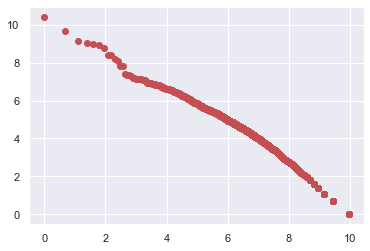

In [28]:
plt.plot(
    [math.log(L - r + 1) for (w, c, r) in counts_sorted],
    [math.log(c) for (w, c, r) in counts_sorted],
    "ro",
)

In [29]:
import numpy as np

In [30]:
# generate x and y
x = [math.log(L - r + 1) for (w, c, r) in counts_sorted]
y = [math.log(c) for (w, c, r) in counts_sorted]
X = np.array(x)
Y = np.array(y)
A = np.vstack([X, np.ones(len(X))]).T
Y_ = Y[:, np.newaxis]
alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T, A)), A.T)), Y_)
print(alpha)

[[-1.30365303]
 [13.01571948]]


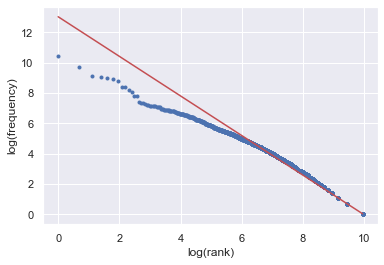

In [31]:
plt.plot(X, Y, "b.")
plt.plot(X, alpha[0] * X + alpha[1], "r")
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.show()

In [33]:
! pip install wordcloud

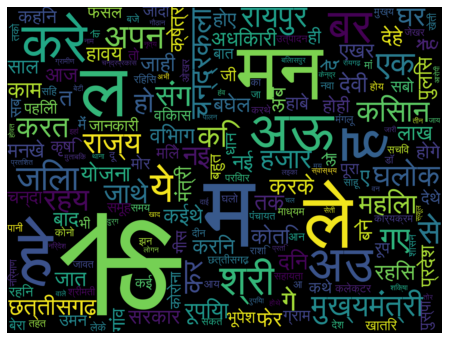

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

font = "gargi.ttf"

wordcloud = WordCloud(
    width=1600,
    height=1200,
    max_font_size=500,
    background_color="black",
        regexp=r"[\u0900-\u097F]+",
    font_path=font,
)

# wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=count_dict)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()